In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
## Suppress warnings related to division by zero
import warnings
warnings.filterwarnings('ignore')
from xhistogram.xarray import histogram
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import gridspec
from scipy import stats

In [2]:
tree_depth = 4

In [3]:
# Thermal expansion, haline contraction and true scale factor
alph = 1.7657*10**-4
bet = 7.5544*10**-4

volnorming = 10**15 #normalising coeffcients
areanorming = 10**12 #normalising coeffcients
ST_scale=bet/alph

# Establish basic constants 
yr2sec = 365.25*24*60*60
dt_OG = xr.open_mfdataset('../BSP_processed/ACCESS_CM2/dtime*.nc').sel(time=slice('1979-01-01',None))
dt_OG['time'] = np.arange(dt_OG.average_DT.size).astype(float)
dt = dt_OG.rename({'time':'Time'})
dt_OG_ACCESS = xr.open_mfdataset('../BSP_processed/ACCESS_CM2/dtime*.nc')
dt_OG_ACCESS['time'] = np.arange(dt_OG_ACCESS.average_DT.size).astype(float)
dt_ACCESS = dt_OG_ACCESS.rename({'time':'Time'})
rho = 1035 #kg/m^3
Cp = 3992.10322329649
S0=35

# Range of years of which 'early' and 'late' are defined

dyrs = 9
init_early = 1979
init_late = 2006
Early_period = (np.array([init_early,init_early+dyrs]) - init_early)*12#+((-1850+1979)*12)
Late_period = (np.array([init_late,init_late+dyrs]) - init_early)*12#+((-1850+1979)*12)
Early_period_OG = (np.array([init_early,init_early+dyrs]) - init_early)*12+((-1850+1979)*12)
Late_period_OG = (np.array([init_late,init_late+dyrs]) - init_early)*12+((-1850+1979)*12)
range_yrs = init_late-init_early+1

weighted_months = np.array([31,28.25,31,30,31,30,31,31,30,31,30,31])
int_scaling = ((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-Early_period[0]))

In [4]:
%%time
# Load ACCESS-CM2 data (this data has already been coarsened into basins and BSP bins)
ACCESS_BSP_data = xr.open_mfdataset('../BSP_processed/ACCESS_CM2/*ACCESS_ERA5_*%i_bins_*.nc' %(tree_depth))
ACCESS_BSP_OG = xr.open_mfdataset('../BSP_processed/ACCESS_CM2/BSP_ACCESS_TS_hist_4_bins_*.nc')

## Early Period
Part_early = ACCESS_BSP_data.Partitions.isel(Time=slice(Early_period[0],Early_period[1])).sum('Time')/(Early_period[1]-Early_period[0])
SA_early =  ACCESS_BSP_data.S_mean.isel(Time=slice(Early_period[0],Early_period[1])).sum('Time')/(Early_period[1]-Early_period[0])
CT_early = (ACCESS_BSP_data.T_mean-273.15).isel(Time=slice(Early_period[0],Early_period[1])).sum('Time')/(Early_period[1]-Early_period[0])
V_early = ACCESS_BSP_data.V_sum.isel(Time=slice(Early_period[0],Early_period[1])).sum('Time')/(Early_period[1]-Early_period[0])
A_early = ACCESS_BSP_data.A_sum.isel(Time=slice(Early_period[0],Early_period[1])).sum('Time')/(Early_period[1]-Early_period[0])
CTV_early = ((ACCESS_BSP_data.T_mean-273.15)*ACCESS_BSP_data.V_sum).isel(Time=slice(Early_period[0],Early_period[1])).sum('Time')/(Early_period[1]-Early_period[0])
SAV_early = (ACCESS_BSP_data.S_mean*ACCESS_BSP_data.V_sum).isel(Time=slice(Early_period[0],Early_period[1])).sum('Time')/(Early_period[1]-Early_period[0])

## Late Period
Part_late = ACCESS_BSP_data.Partitions.isel(Time=slice(Late_period[0],Late_period[1])).sum('Time')/(Late_period[1]-Late_period[0])
SA_late =  ACCESS_BSP_data.S_mean.isel(Time=slice(Late_period[0],Late_period[1])).sum('Time')/(Late_period[1]-Late_period[0])
CT_late = (ACCESS_BSP_data.T_mean-273.15).isel(Time=slice(Late_period[0],Late_period[1])).sum('Time')/(Late_period[1]-Late_period[0])-273.15
V_late = ACCESS_BSP_data.V_sum.isel(Time=slice(Late_period[0],Late_period[1])).sum('Time')/(Late_period[1]-Late_period[0])
A_late = ACCESS_BSP_data.A_sum.isel(Time=slice(Late_period[0],Late_period[1])).sum('Time')/(Late_period[1]-Late_period[0])
CTV_late = ((ACCESS_BSP_data.T_mean-273.15)*ACCESS_BSP_data.V_sum).isel(Time=slice(Late_period[0],Late_period[1])).sum('Time')/(Late_period[1]-Late_period[0])
SAV_late = (ACCESS_BSP_data.S_mean*ACCESS_BSP_data.V_sum).isel(Time=slice(Late_period[0],Late_period[1])).sum('Time')/(Late_period[1]-Late_period[0])

Basins = ACCESS_BSP_data.Basin.values

CPU times: user 765 ms, sys: 56.8 ms, total: 822 ms
Wall time: 964 ms


In [5]:
dt.average_DT

<xarray.DataArray 'average_DT' (Time: 432)>
dask.array<getitem, shape=(432,), dtype=float64, chunksize=(432,), chunktype=numpy.ndarray>
Coordinates:
  * Time     (Time) float64 0.0 1.0 2.0 3.0 4.0 ... 428.0 429.0 430.0 431.0

In [6]:

# Flatten the early and late variables to a 1D array
Vol_1 = V_early.values.flatten()
Vol_2 = V_late.values.flatten()
S_1 = SAV_early.values.flatten()/Vol_1-S0 # Remove reference salinity S0
S_2 = SAV_late.values.flatten()/Vol_2-S0 # Remove reference salinity S0
T_1 = CTV_early.values.flatten()/Vol_1
T_2 = CTV_late.values.flatten()/Vol_2
A_1 = A_early.values.flatten()
A_2 = A_late.values.flatten()


# Do the same for basin index
Basin_1 = np.zeros_like(V_early)
Basin_2 = np.zeros_like(V_early)
Basin_names = []
for i in range(np.array(Basins).size):
    Basin_1[i,:] = i
    Basin_2[i,:] = i
    for j in range(V_early.shape[-1]):
        #... and for basin name
        Basin_names.append(Basins[i])

Basin_1_inds = Basin_1.flatten()
Basin_2_inds = Basin_2.flatten()

#... and for the edges of the BSP bins
## Here we calculate the mean TS edges averaged over both early and late times
S_start = (0.5*(Part_early.values[:,:,0]+Part_late.values[:,:,0])).flatten()-S0 # Remove reference salinity S0
S_end = (0.5*(Part_early.values[:,:,1]+Part_late.values[:,:,1])).flatten()-S0 # Remove reference salinity S0
T_start = (0.5*(Part_early.values[:,:,2]+Part_late.values[:,:,2])).flatten()
T_end = (0.5*(Part_early.values[:,:,3]+Part_late.values[:,:,3])).flatten()

# Any NaNs are zeroed out
S_1[np.isnan(S_1)] = 0
S_2[np.isnan(S_2)] = 0
T_1[np.isnan(T_1)] = 0
T_2[np.isnan(T_2)] = 0

In [7]:
## Load SF data here, if provided
## Calculate the cumulative time integrated surface fluxes 
HFDS_cumsum = (((ACCESS_BSP_data.hfds_sum)*dt.average_DT).cumsum('Time').isel(Time=-1))\
    -(((ACCESS_BSP_data.hfds_sum)*dt.average_DT).cumsum('Time').isel(Time=Early_period[0])) # units: J
WFO_cumsum = ((ACCESS_BSP_data.wfo_sum)*dt.average_DT).cumsum('Time').isel(Time=-1)\
        -(((ACCESS_BSP_data.wfo_sum)*dt.average_DT).cumsum('Time').isel(Time=Early_period[0]))# units: kg
HFDS_cumsum_OG = (((ACCESS_BSP_OG.hfds_sum)*dt_ACCESS.average_DT).cumsum('Time').isel(Time=-1))\
    -(((ACCESS_BSP_OG.hfds_sum)*dt_ACCESS.average_DT).cumsum('Time').isel(Time=Early_period_OG[0])) # units: J
WFO_cumsum_OG = ((ACCESS_BSP_OG.wfo_sum)*dt_ACCESS.average_DT).cumsum('Time').isel(Time=-1)\
        -(((ACCESS_BSP_OG.wfo_sum)*dt_ACCESS.average_DT).cumsum('Time').isel(Time=Early_period_OG[0]))# units: kg

## The final dflux value is then scaled by the time between the middle of t1 and the middle of t2
dhfds = HFDS_cumsum*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-Early_period[0]))
dwfo = WFO_cumsum*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-Early_period[0]))
dhfds_OG = HFDS_cumsum_OG*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-Early_period[0]))
dwfo_OG = WFO_cumsum_OG*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-Early_period[0]))


## Get it in W/m2 and mm/day
dhfds_flux = dhfds/(range_yrs*yr2sec*A_early)
dwfo_flux = dwfo/(range_yrs*yr2sec*A_early*rho)*1000*24*3600

## Convert dflux to equivalent T or S change
dT_prior = (dhfds/(Cp*rho*V_early)).values.flatten() # units: C
dS_prior = (-dwfo*S0/(rho*V_early)).values.flatten() # units: g/kg
dT_prior_OG = (dhfds_OG/(Cp*rho*V_early)).values.flatten() # units: C
dS_prior_OG = (-dwfo_OG*S0/(rho*V_early)).values.flatten() # units: g/kg

time = ACCESS_BSP_data.Time.values    

## Add the Q_prior to S_0; T_0 to get the 'initial' state ##
S_pre = SAV_early.values.flatten()/Vol_1-S0
S_1 = SAV_early.values.flatten()/Vol_1-S0+dS_prior
T_pre = CTV_early.values.flatten()/Vol_1
T_1 = CTV_early.values.flatten()/Vol_1+dT_prior
S_1[np.isnan(S_1)] = 0
T_1[np.isnan(T_1)] = 0
S_1[~np.isfinite(S_1)] = 0
T_1[~np.isfinite(T_1)] = 0
S_pre[np.isnan(S_pre)] = 0
T_pre[np.isnan(T_pre)] = 0
S_pre[~np.isfinite(S_pre)] = 0
T_pre[~np.isfinite(T_pre)] = 0


In [8]:

data_ACCESS_wfo = xr.open_mfdataset('~/UNSW_Work/ACCESS_CM2/wfo_ACCESS_hist_proper.nc').sel(time=slice('1979-01-01',None)) ## hfds: Wm^-2; wfo: kgm^-2s^-1
data_ACCESS_hfds = xr.open_mfdataset('~/UNSW_Work/ACCESS_CM2/hfds_ACCESS_hist_proper.nc').sel(time=slice('1979-01-01',None)) ## hfds: Wm^-2; wfo: kgm^-2s^-1
ACCESS_dArea = xr.open_mfdataset('~/UNSW_Work/ACCESS_CM2/darea_ACCESS_hist_proper.nc').sel(time=slice('1979-01-01',None)).mean('time')
ACCESS_dArea_masked = data_ACCESS_hfds.__xarray_dataarray_variable__.isel(time=0)/data_ACCESS_hfds.__xarray_dataarray_variable__.isel(time=0)*ACCESS_dArea.area_t
data_ERA5_SF = xr.open_mfdataset('~/UNSW_Work/ERA5/ERA5_interped_ACCESS.nc') ## hfds: Wm^-2; wfo: kgm^-2s^-1
data_ERA5_SF['time'] = data_ACCESS_wfo.time

data_ERA5_wfo = data_ERA5_SF.wfo
data_ERA5_hfds = data_ERA5_SF.hfds
data_ACCESS_dtime = xr.open_mfdataset('../BSP_processed/ACCESS_CM2/dtime*.nc').sel(time=slice('1979-01-01',None))


In [9]:

## Calculate the cumulative time integrated surface fluxes 
hfds_ACCESS_cumsum = (data_ACCESS_hfds.__xarray_dataarray_variable__*data_ACCESS_dtime.average_DT).\
    isel(time=slice(Early_period[0], Late_period[-1])).cumsum('time').isel(time=-1) # UNITS: [J/m2]

wfo_ACCESS_cumsum = (data_ACCESS_wfo.pme_river*data_ACCESS_dtime.average_DT).\
    isel(time=slice(Early_period[0], Late_period[-1])).cumsum('time').isel(time=-1) # UNITS: [kg/m2]

hfds_ACCESS = hfds_ACCESS_cumsum*int_scaling*(1/(range_yrs*yr2sec)) # UNITS: [W/m2]
hfds_ACCESS_J = hfds_ACCESS_cumsum*int_scaling*ACCESS_dArea_masked # UNITS: [J]

wfo_ACCESS_kg_m2_s = wfo_ACCESS_cumsum*int_scaling*(1/(range_yrs*yr2sec)) # UNITS: [kg/m2/s]
wfo_ACCESS = wfo_ACCESS_kg_m2_s/(rho)*24*3600*1000 # UNITS: mm/day
wfo_ACCESS_m3 = wfo_ACCESS_cumsum*int_scaling*ACCESS_dArea_masked/rho

hfds_ACCESS_J.load()
hfds_ACCESS.load()    
wfo_ACCESS_m3.load()
wfo_ACCESS.load()

<xarray.DataArray (yt_ocean: 300, xt_ocean: 360)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
    time      datetime64[ns] 2014-12-16T12:00:00
    geolat_t  (yt_ocean, xt_ocean) float32 -77.88 -77.88 -77.88 ... 65.63 65.21
    geolon_t  (yt_ocean, xt_ocean) float32 -279.5 -278.5 -277.5 ... 79.97 79.99

In [10]:
%%time
## Calculate the cumulative time integrated surface fluxes 
hfds_ERA5_cumsum = (data_ERA5_hfds*data_ACCESS_dtime.average_DT).\
    isel(time=slice(Early_period[0], Late_period[-1])).cumsum('time').isel(time=-1) # UNITS: [J/m2]
wfo_ERA5_cumsum = (data_ERA5_wfo*data_ACCESS_dtime.average_DT).\
    isel(time=slice(Early_period[0], Late_period[-1])).cumsum('time').isel(time=-1) # UNITS: [kg/m2]

hfds_ERA5 = hfds_ERA5_cumsum*int_scaling*(1/(range_yrs*yr2sec)) # UNITS: [W/m2]
hfds_ERA5_J = hfds_ERA5_cumsum*int_scaling*ACCESS_dArea_masked # UNITS: [J]

wfo_ERA5_kg_m2_s = wfo_ERA5_cumsum*int_scaling*(1/(range_yrs*yr2sec)) # UNITS: [kg/m2/s]
wfo_ERA5 = wfo_ERA5_kg_m2_s/(rho)*24*3600*1000 # UNITS: mm/day
wfo_ERA5_m3 = wfo_ERA5_cumsum*int_scaling*ACCESS_dArea_masked/rho

hfds_ERA5_J.load()
hfds_ERA5.load()
wfo_ERA5_m3.load()
wfo_ERA5.load()

CPU times: user 3.98 s, sys: 3.29 s, total: 7.27 s
Wall time: 5.58 s


<xarray.DataArray (yt_ocean: 300, xt_ocean: 360)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.03114541, 0.01039151, 0.02061891, ..., 0.00578929, 0.01399522,
        0.02781088],
       [0.03085811, 0.01167323, 0.01538125, ..., 0.00647499, 0.01383808,
        0.02885736],
       [0.03059759, 0.0129714 , 0.01008386, ..., 0.00711081, 0.0136942 ,
        0.02992953]])
Coordinates:
    expver     int32 1
    time       datetime64[ns] 2014-12-16T12:00:00
    latitude   (yt_ocean, xt_ocean) float32 -77.88 -77.88 -77.88 ... 65.63 65.21
    longitude  (yt_ocean, xt_ocean) float32 -279.5 -278.5 -277.5 ... 79.97 79.99
  * xt_ocean   (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean   (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77

In [11]:
Opt_result = xr.open_mfdataset('../Optimisation_results/ACCESS_CM2_ERA5_Q_prior_transports.nc')

RAPID_example = xr.open_mfdataset('~/UNSW_Work/RAPID_AMOC/moc_transports.nc')
    
mean_MOC_RAPID = RAPID_example.moc_mar_hc10.mean('time').values

In [12]:
ACCESS_mapped_masks = xr.open_mfdataset('../Masks_processed/ACCESS_mask_%i_bins_7*.nc' %(tree_depth))
ACCESS_mapped_masks.salt

<xarray.DataArray 'salt' (tree_depth: 16, time: 540, yt_ocean: 300, xt_ocean: 360)>
dask.array<open_dataset-e5d6cd01b29ff7cb95a77ef96e2f7d05salt, shape=(16, 540, 300, 360), dtype=float32, chunksize=(16, 540, 300, 360), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean    (xt_ocean) float64 -279.5 -278.5 -277.5 ... 77.5 78.5 79.5
  * yt_ocean    (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
  * time        (time) datetime64[ns] 1970-01-16T12:00:00 ... 2014-12-16T12:0...
    st_ocean    float64 ...
    geolat_t    (yt_ocean, xt_ocean) float32 dask.array<chunksize=(300, 360), meta=np.ndarray>
    geolon_t    (yt_ocean, xt_ocean) float32 dask.array<chunksize=(300, 360), meta=np.ndarray>
  * tree_depth  (tree_depth) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
Attributes:
    long_name:      Practical Salinity
    units:          psu
    valid_range:    [-10. 100.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_salinity

In [13]:
ACCESS_mapped_masks = xr.open_mfdataset('../Masks_processed/ACCESS_mask_%i_bins_7*.nc' %(tree_depth))

if tree_depth<=4:
    fuzz_combined = (ACCESS_mapped_masks.salt.isel(time=slice(Early_period[-1],Early_period[-1]+(9*12))).sum('time')/(dyrs*12)).values
else:
    fuzz_combined = (ACCESS_mapped_masks.salt.sum('time')/(dyrs*12)).values

mask_ACCESS_xr = xr.open_mfdataset('../Basin_mask/mask_ACCESS.nc')

mask_ACCESS = (mask_ACCESS_xr.mask_ACCESS.isel(st_ocean=0).values)
## Load SF data here, if provided
dhfds_flux_vals = dhfds_flux.values
dwfo_flux_vals = dwfo_flux.values

dS_adj = Opt_result.dS_adjustment.values.reshape(Basins.size,SA_late.shape[-1])
dT_adj = Opt_result.dT_adjustment.values.reshape(Basins.size,SA_late.shape[-1])

dwfo_adj = -dS_adj*(rho*V_late.values)/S0 # units: kg # swapped from V_early
dhfds_adj = dT_adj*(Cp*rho*V_late.values) # units: J # swapped from V_early

## Get it in W/m2 and mm/day
dhfds_flux_adj = dhfds_adj/(range_yrs*yr2sec*A_late.values) # swapped from V_early
dwfo_flux_adj = dwfo_adj/(range_yrs*yr2sec*A_late.values*rho)*1000*24*3600 # swapped from V_early

In [14]:
## Do the calculation for the actual ACCESS heat fluxes
# Range of years of which 'early' and 'late' are defined

Early_period_ACCESS = (np.array([init_early,init_early+dyrs]) - init_early)*12+((-1850+1979)*12)
Late_period_ACCESS = (np.array([init_late,init_late+dyrs]) - init_early)*12+((-1850+1979)*12)

ACCESS_true_BSP_data = xr.open_mfdataset('../BSP_processed/ACCESS_CM2/BSP_ACCESS_TS_hist_4_bins_*.nc')

dt_OG_full = xr.open_mfdataset('../BSP_processed/ACCESS_CM2/dtime*.nc')
dt_OG_full['time'] = np.arange(dt_OG_full.average_DT.size).astype(float)
dt_full = dt_OG_full.rename({'time':'Time'})

## Load SF data here, if provided
## Calculate the cumulative time integrated surface fluxes 
HFDS_cumsum_ACCESS = (((ACCESS_true_BSP_data.hfds_sum)*dt_full.average_DT).cumsum('Time').isel(Time=-1))\
    -(((ACCESS_true_BSP_data.hfds_sum)*dt_full.average_DT).cumsum('Time').isel(Time=Early_period_ACCESS[0])) # units: J
WFO_cumsum_ACCESS = ((ACCESS_true_BSP_data.wfo_sum)*dt_full.average_DT).cumsum('Time').isel(Time=-1)\
        -(((ACCESS_true_BSP_data.wfo_sum)*dt_full.average_DT).cumsum('Time').isel(Time=Early_period_ACCESS[0]))# units: kg

## The final dflux value is then scaled by the time between the middle of t1 and the middle of t2
dhfds_ACCESS = HFDS_cumsum_ACCESS*int_scaling
dwfo_ACCESS = WFO_cumsum_ACCESS*int_scaling

## Get it in W/m2 and mm/day
dhfds_flux_ACCESS = dhfds_ACCESS/(range_yrs*yr2sec*A_early)
dwfo_flux_ACCESS = dwfo_ACCESS/(range_yrs*yr2sec*A_early*rho)*1000*24*3600

## Load SF data here, if provided
dhfds_flux_vals_ACCESS = dhfds_flux_ACCESS.values
dwfo_flux_vals_ACCESS = dwfo_flux_ACCESS.values


In [15]:
hfds_tot = 0
wfo_tot = 0
for i in (range(SA_early.shape[-1])):
        tmp_dhfds = 0
        tmp_dwfo = 0
        for j in range(Basins.size):
                tmp = mask_ACCESS[j,:,:]*fuzz_combined[i,:,:]*dhfds_flux_vals[j,i]
                tmp[np.isnan(tmp)] = 0
                tmp_dhfds = tmp+tmp_dhfds
                tmp = mask_ACCESS[j,:,:]*fuzz_combined[i,:,:]*dwfo_flux_vals[j,i]
                tmp[np.isnan(tmp)] = 0
                tmp_dwfo = tmp+tmp_dwfo
        hfds_tot = tmp_dhfds+hfds_tot
        wfo_tot = tmp_dwfo+wfo_tot

hfds_tot_ACCESS = 0
wfo_tot_ACCESS = 0
for i in (range(SA_early.shape[-1])):
        tmp_dhfds = 0
        tmp_dwfo = 0
        for j in range(Basins.size):
                tmp = mask_ACCESS[j,:,:]*fuzz_combined[i,:,:]*dhfds_flux_vals_ACCESS[j,i]
                tmp[np.isnan(tmp)] = 0
                tmp_dhfds = tmp+tmp_dhfds
                tmp = mask_ACCESS[j,:,:]*fuzz_combined[i,:,:]*dwfo_flux_vals_ACCESS[j,i]
                tmp[np.isnan(tmp)] = 0
                tmp_dwfo = tmp+tmp_dwfo
        hfds_tot_ACCESS = tmp_dhfds+hfds_tot_ACCESS
        wfo_tot_ACCESS = tmp_dwfo+wfo_tot_ACCESS


In [16]:
dS_adj_stacked = Opt_result.dS_adjustment
dT_adj_stacked = Opt_result.dT_adjustment

ds_vol_late_stacked = V_late.stack(WM_number = ['Basin', 'Depth'])
ds_vol_late_stacked['WM_number'] = np.arange(0,144)
ds_area_late_stacked = A_late.stack(WM_number = ['Basin', 'Depth'])
ds_area_late_stacked['WM_number'] = np.arange(0,144)
ds_area_early_stacked = A_early.stack(WM_number = ['Basin', 'Depth'])
ds_area_early_stacked['WM_number'] = np.arange(0,144)

mask_WM_basin = mask_ACCESS_xr.mask_ACCESS.isel(st_ocean=0)*(ACCESS_mapped_masks.salt.isel(time=slice(Early_period[0],Early_period[-1])).sum('time')/(dyrs*12))
mask_WM_basin_stacked = mask_WM_basin.stack(WM_number = ['Basins', 'tree_depth'])
mask_WM_basin_stacked['WM_number'] = np.arange(0,144)

### Adjustment in W/m2 for maps
dhfds_adj_Wm2 = dT_adj_stacked*ds_vol_late_stacked*rho*Cp/(range_yrs*yr2sec*ds_area_late_stacked)
dhfds_adj_remapped_Wm2_bias = (dhfds_adj_Wm2.where(abs(dhfds_adj_Wm2)!=np.inf, 0)*mask_WM_basin_stacked).sum('WM_number')

### Adjustment in J for the heat budget
dhfds_adj_J = dT_adj_stacked*ds_vol_late_stacked*rho*Cp/ds_area_late_stacked

dhfds_adj_remapped_J_bias = (dhfds_adj_J.where(abs(dhfds_adj_J)!=np.inf, 0)*mask_WM_basin_stacked).sum('WM_number')*ACCESS_dArea_masked

dhfds_adj_J_missing = ((dT_adj_stacked*ds_vol_late_stacked*rho*Cp).sum('WM_number')-\
                                (dhfds_adj_remapped_J_bias).sum(['xt_ocean','yt_ocean']))

dhfds_adj_remapped_Wm2_missing = dhfds_adj_J_missing/(range_yrs*yr2sec*np.nansum(ACCESS_dArea_masked.values))
dhfds_adj_remapped_Wm2 = dhfds_adj_remapped_Wm2_bias+dhfds_adj_remapped_Wm2_missing
dhfds_adj_remapped_J = dhfds_adj_remapped_J_bias+dhfds_adj_J_missing/(np.nansum(ACCESS_dArea_masked.values))*ACCESS_dArea_masked

In [17]:
dwfo_adj_mm_day = -dS_adj_stacked*ds_vol_late_stacked/(range_yrs*yr2sec*ds_area_late_stacked*S0)*24*3600*1000
dwfo_adj_remapped_mm_day_bias = (dwfo_adj_mm_day.where(abs(dwfo_adj_mm_day)!=np.inf, 0)*mask_WM_basin_stacked).sum('WM_number')

### Adjustment in m3 for the FW budget
dwfo_adj_m3 = -dS_adj_stacked*ds_vol_late_stacked/(S0*ds_area_late_stacked)
dwfo_adj_remapped_m3_bias = (dwfo_adj_m3.where(abs(dwfo_adj_m3)!=np.inf, 0)*mask_WM_basin_stacked).sum('WM_number')*ACCESS_dArea_masked

dwfo_adj_m3_missing = ((-dS_adj_stacked*ds_vol_late_stacked/S0).sum('WM_number')-\
                                (dwfo_adj_remapped_m3_bias).sum(['xt_ocean','yt_ocean']))

dwfo_adj_remapped_mm_day_missing = dwfo_adj_m3_missing/(range_yrs*yr2sec*np.nansum(ACCESS_dArea_masked.values))*24*3600*1000
dwfo_adj_remapped_mm_day = dwfo_adj_remapped_mm_day_bias+dwfo_adj_remapped_mm_day_missing
dwfo_adj_remapped_m3 = dwfo_adj_remapped_m3_bias+dwfo_adj_m3_missing/(np.nansum(ACCESS_dArea_masked.values))*ACCESS_dArea_masked

In [18]:
lats = data_ACCESS_hfds.geolat_t.values
lons = data_ACCESS_hfds.geolon_t.values

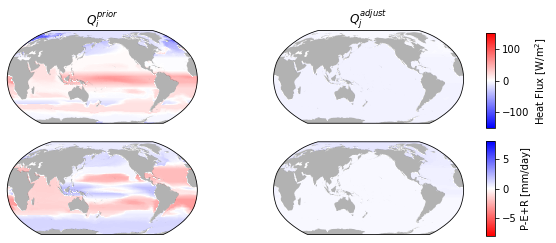

In [19]:
fig  = plt.figure(1, figsize = (17.5*0.5, 7.5*0.5))
gs = gridspec.GridSpec(2,2)
gs.update(wspace = 0.2, hspace=0.2)

ax1, ax2, ax3, ax4 = plt.subplot(gs[0,0], projection=ccrs.Robinson(central_longitude=180)), \
        plt.subplot(gs[0,1], projection=ccrs.Robinson(central_longitude=180)),\
        plt.subplot(gs[1,0], projection=ccrs.Robinson(central_longitude=180)),\
        plt.subplot(gs[1,1], projection=ccrs.Robinson(central_longitude=180))

minv, maxv = -150,150

ax1.pcolormesh(lons, lats,  hfds_tot, vmin=minv,vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree())


ax2.pcolormesh(lons, lats,  dhfds_adj_remapped_Wm2, vmin=minv,vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree())

cax = fig.add_axes([0.91, 0.52, 0.015, 0.35])
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('Heat Flux [W/m$^2$]')

minv, maxv = -8,8

ax3.pcolormesh(lons, lats, wfo_tot, vmin=minv,vmax=maxv, cmap=plt.cm.bwr_r,  transform = ccrs.PlateCarree())

ax4.pcolormesh(lons, lats, dwfo_adj_remapped_mm_day, vmin=minv,vmax=maxv, cmap=plt.cm.bwr_r,  transform = ccrs.PlateCarree())

ax1.set_title(r'$Q_i^{prior}$')
ax2.set_title(r'$Q_j^{adjust}$')
ax3.set_title('')
# ax4.set_title('Accumulated P-E+R (Remapped)')

ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
ax3.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
ax4.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))

cax = fig.add_axes([0.91, 0.12, 0.015, 0.35])
m = plt.cm.ScalarMappable(cmap='bwr_r')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical') 
cbar.set_label('P-E+R [mm/day]')
# plt.savefig('../Figures/hfds_wfo_adj_vs_actual_ACCESS.png', bbox_inches='tight', dpi=300)
plt.show()

In [20]:
# print(np.std(dhfds_adj_remapped_Wm2[np.isfinite(dhfds_adj_remapped_Wm2)]))
# print(np.std(dwfo_adj_remapped_mm_day[np.isfinite(dwfo_adj_remapped_mm_day)]))
# print(np.std(hfds_tot[np.isfinite(hfds_tot)]))
# print(np.std(wfo_tot[np.isfinite(wfo_tot)]))

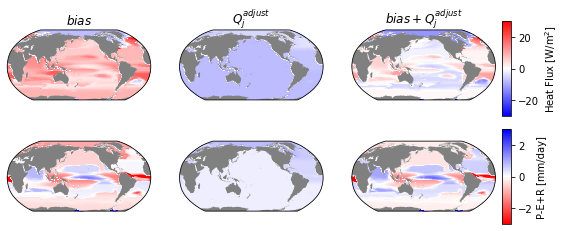

In [21]:
fig  = plt.figure(1, figsize = (17.5*0.5, 7.5*0.5))
gs = gridspec.GridSpec(2,3)
gs.update(wspace = 0.2, hspace=0.2)

ax1, ax2, ax3, ax4, ax5, ax6 = plt.subplot(gs[0,0], projection=ccrs.Robinson(central_longitude=180)), \
        plt.subplot(gs[0,1], projection=ccrs.Robinson(central_longitude=180)),\
        plt.subplot(gs[0,2], projection=ccrs.Robinson(central_longitude=180)),\
        plt.subplot(gs[1,0], projection=ccrs.Robinson(central_longitude=180)),\
        plt.subplot(gs[1,1], projection=ccrs.Robinson(central_longitude=180)),\
        plt.subplot(gs[1,2], projection=ccrs.Robinson(central_longitude=180))

minv, maxv = -1*np.nanmax(hfds_tot-hfds_tot_ACCESS),np.nanmax(hfds_tot-hfds_tot_ACCESS)

ax1.pcolormesh(lons, lats,  hfds_tot-hfds_tot_ACCESS, vmin=minv,vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree())


ax2.pcolormesh(lons, lats,  dhfds_adj_remapped_Wm2, vmin=minv,vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree())

ax3.pcolormesh(lons, lats,  hfds_tot-hfds_tot_ACCESS+dhfds_adj_remapped_Wm2, vmin=minv,vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree())

cax = fig.add_axes([0.91, 0.52, 0.015, 0.35])
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('Heat Flux [W/m$^2$]')

minv, maxv = -3,3

ax4.pcolormesh(lons, lats, wfo_tot-wfo_tot_ACCESS, vmin=minv,vmax=maxv, cmap=plt.cm.bwr_r,  transform = ccrs.PlateCarree())

ax5.pcolormesh(lons, lats, dwfo_adj_remapped_mm_day, vmin=minv,vmax=maxv, cmap=plt.cm.bwr_r,  transform = ccrs.PlateCarree())

ax6.pcolormesh(lons, lats, wfo_tot-wfo_tot_ACCESS+dwfo_adj_remapped_mm_day, vmin=minv,vmax=maxv, cmap=plt.cm.bwr_r,  transform = ccrs.PlateCarree())


ax1.set_title(r'$bias$')
ax2.set_title(r'$Q_j^{adjust}$')
ax3.set_title(r'$bias+Q_j^{adjust}$')

ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=1))
ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=1))
ax3.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=1))
ax4.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=1))
ax5.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=1))
ax6.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=1))

cax = fig.add_axes([0.91, 0.12, 0.015, 0.35])
m = plt.cm.ScalarMappable(cmap='bwr_r')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical') 
cbar.set_label('P-E+R [mm/day]')
plt.savefig('../Figures/hfds_wfo_adj_vs_offset_ERA5.png', bbox_inches='tight', dpi=300)
plt.show()

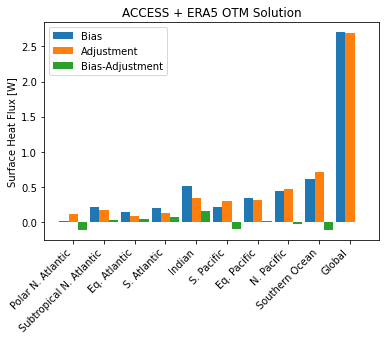

In [22]:
basin_scale_bias = ((hfds_tot-hfds_tot_ACCESS)*ACCESS_dArea_masked*mask_ACCESS_xr.mask_ACCESS.isel(st_ocean=0)).sum(['xt_ocean','yt_ocean']) #W
basin_scale_adj = ((dhfds_adj_remapped_Wm2)*ACCESS_dArea_masked*mask_ACCESS_xr.mask_ACCESS.isel(st_ocean=0)).sum(['xt_ocean','yt_ocean']) #W
basin_scale_residual = basin_scale_bias+basin_scale_adj

labels = np.append(basin_scale_bias.Basins.values, 'Global')
x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()

ax.bar(x- width, np.append(basin_scale_bias.values, basin_scale_bias.sum('Basins').values)/1e15, width, label = 'Bias')
ax.bar(x, -np.append(basin_scale_adj.values, basin_scale_adj.sum('Basins').values)/1e15, width, label = 'Adjustment')
ax.bar(x+ width, np.append(basin_scale_residual.values, basin_scale_residual.sum('Basins').values)/1e15, width, label = 'Bias-Adjustment')

ax.set_ylabel('Surface Heat Flux [W]')
ax.set_title('ACCESS + ERA5 OTM Solution')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend()
plt.savefig('../Figures/ACCESS_ERA5_Basin_bars_hfds.png', dpi=300, bbox_inches='tight')
plt.show()


In [23]:
np.append(basin_scale_bias.values, basin_scale_bias.sum('Basins').values)

array([1.34614942e+13, 2.13498052e+14, 1.41341063e+14, 1.99518894e+14,
       5.14002335e+14, 2.19195863e+14, 3.42808259e+14, 4.44334083e+14,
       6.11105898e+14, 2.69926594e+15])

In [25]:
# print((np.sqrt(np.mean(np.square(((wfo_tot-wfo_tot_ACCESS+dwfo_adj_remapped_mm_day)[np.isfinite(wfo_tot-wfo_tot_ACCESS+dwfo_adj_remapped_mm_day)])))))/\
# np.sqrt(np.mean(np.square(wfo_tot_ACCESS))))
# print((np.sqrt(np.mean(np.square(((hfds_tot-hfds_tot_ACCESS+dhfds_adj_remapped_Wm2)[np.isfinite(hfds_tot-hfds_tot_ACCESS+dhfds_adj_remapped_Wm2)])))))/\
# np.sqrt(np.mean(np.square(hfds_tot_ACCESS))))
# print((np.sqrt(np.mean(np.square(((wfo_tot-wfo_tot_ACCESS)[np.isfinite(wfo_tot-wfo_tot_ACCESS)])))))/\
# np.sqrt(np.mean(np.square(wfo_tot_ACCESS))))
# print((np.sqrt(np.mean(np.square(((hfds_tot-hfds_tot_ACCESS)[np.isfinite(hfds_tot-hfds_tot_ACCESS)])))))/\
# np.sqrt(np.mean(np.square(hfds_tot_ACCESS))))


In [26]:
hfds_lat_binned_global = xr.open_mfdataset('../../ACCESS_CM2/hfds_lat_binned_global.nc')
OHC_lat_binned_global = xr.open_mfdataset('../../ACCESS_CM2/OHC_lat_binned_global.nc')

hfds_lat_binned_Atl = xr.open_mfdataset('../../ACCESS_CM2/hfds_lat_binned_Atl.nc')
OHC_lat_binned_Atl = xr.open_mfdataset('../../ACCESS_CM2/OHC_lat_binned_Atl.nc')

hfds_lat_binned_Pac = xr.open_mfdataset('../../ACCESS_CM2/hfds_lat_binned_Pac.nc')
OHC_lat_binned_Pac = xr.open_mfdataset('../../ACCESS_CM2/OHC_lat_binned_Pac.nc')

hfds_lat_binned_Ind = xr.open_mfdataset('../../ACCESS_CM2/hfds_lat_binned_Ind.nc')
OHC_lat_binned_Ind = xr.open_mfdataset('../../ACCESS_CM2/OHC_lat_binned_Ind.nc')

hfds_lat_binned_SO = xr.open_mfdataset('../../ACCESS_CM2/hfds_lat_binned_SO.nc')
OHC_lat_binned_SO = xr.open_mfdataset('../../ACCESS_CM2/OHC_lat_binned_SO.nc')

In [27]:
wfo_lat_binned_global = xr.open_mfdataset('../../ACCESS_CM2/wfo_lat_binned_global.nc')
OSC_lat_binned_global = xr.open_mfdataset('../../ACCESS_CM2/OSC_lat_binned_global.nc')

wfo_lat_binned_Atl = xr.open_mfdataset('../../ACCESS_CM2/wfo_lat_binned_Atl.nc')
OSC_lat_binned_Atl = xr.open_mfdataset('../../ACCESS_CM2/OSC_lat_binned_Atl.nc')

wfo_lat_binned_Pac = xr.open_mfdataset('../../ACCESS_CM2/wfo_lat_binned_Pac.nc')
OSC_lat_binned_Pac = xr.open_mfdataset('../../ACCESS_CM2/OSC_lat_binned_Pac.nc')

wfo_lat_binned_Ind = xr.open_mfdataset('../../ACCESS_CM2/wfo_lat_binned_Ind.nc')
OSC_lat_binned_Ind = xr.open_mfdataset('../../ACCESS_CM2/OSC_lat_binned_Ind.nc')

wfo_lat_binned_SO = xr.open_mfdataset('../../ACCESS_CM2/wfo_lat_binned_SO.nc')
OSC_lat_binned_SO = xr.open_mfdataset('../../ACCESS_CM2/OSC_lat_binned_SO.nc')

In [28]:
OHC_early_lat_global = OHC_lat_binned_global.isel(time=slice(Early_period_ACCESS[0],Early_period_ACCESS[1])).mean('time') # J
OHC_late_lat_global = OHC_lat_binned_global.isel(time=slice(Late_period_ACCESS[0],Late_period_ACCESS[1])).mean('time') # J
hfds_early_lat_global = hfds_lat_binned_global.isel(time=slice(Early_period_ACCESS[0],Early_period_ACCESS[1])).mean('time') # J
hfds_late_lat_global = hfds_lat_binned_global.isel(time=slice(Late_period_ACCESS[0],Late_period_ACCESS[1])).mean('time') # J
hfds_lat_change_global = ((hfds_late_lat_global-hfds_early_lat_global)/(range_yrs*yr2sec*10**15)) # units: PW
OHC_lat_change_global = ((OHC_late_lat_global-OHC_early_lat_global)/(range_yrs*yr2sec*10**15)) # units: PW

OHC_early_lat_Atl = OHC_lat_binned_Atl.isel(time=slice(Early_period_ACCESS[0],Early_period_ACCESS[1])).mean('time') # J
OHC_late_lat_Atl = OHC_lat_binned_Atl.isel(time=slice(Late_period_ACCESS[0],Late_period_ACCESS[1])).mean('time') # J
hfds_early_lat_Atl = hfds_lat_binned_Atl.isel(time=slice(Early_period_ACCESS[0],Early_period_ACCESS[1])).mean('time') # J
hfds_late_lat_Atl = hfds_lat_binned_Atl.isel(time=slice(Late_period_ACCESS[0],Late_period_ACCESS[1])).mean('time') # J
hfds_lat_change_Atl = ((hfds_late_lat_Atl-hfds_early_lat_Atl)/(range_yrs*yr2sec*10**15)) # units: PW
OHC_lat_change_Atl = ((OHC_late_lat_Atl-OHC_early_lat_Atl)/(range_yrs*yr2sec*10**15)) # units: PW

OHC_early_lat_Pac = OHC_lat_binned_Pac.isel(time=slice(Early_period_ACCESS[0],Early_period_ACCESS[1])).mean('time') # J
OHC_late_lat_Pac = OHC_lat_binned_Pac.isel(time=slice(Late_period_ACCESS[0],Late_period_ACCESS[1])).mean('time') # J
hfds_early_lat_Pac = hfds_lat_binned_Pac.isel(time=slice(Early_period_ACCESS[0],Early_period_ACCESS[1])).mean('time') # J
hfds_late_lat_Pac = hfds_lat_binned_Pac.isel(time=slice(Late_period_ACCESS[0],Late_period_ACCESS[1])).mean('time') # J
hfds_lat_change_Pac = ((hfds_late_lat_Pac-hfds_early_lat_Pac)/(range_yrs*yr2sec*10**15)) # units: PW
OHC_lat_change_Pac = ((OHC_late_lat_Pac-OHC_early_lat_Pac)/(range_yrs*yr2sec*10**15)) # units: PW

OHC_early_lat_Ind = OHC_lat_binned_Ind.isel(time=slice(Early_period_ACCESS[0],Early_period_ACCESS[1])).mean('time') # J
OHC_late_lat_Ind = OHC_lat_binned_Ind.isel(time=slice(Late_period_ACCESS[0],Late_period_ACCESS[1])).mean('time') # J
hfds_early_lat_Ind = hfds_lat_binned_Ind.isel(time=slice(Early_period_ACCESS[0],Early_period_ACCESS[1])).mean('time') # J
hfds_late_lat_Ind = hfds_lat_binned_Ind.isel(time=slice(Late_period_ACCESS[0],Late_period_ACCESS[1])).mean('time') # J
hfds_lat_change_Ind = ((hfds_late_lat_Ind-hfds_early_lat_Ind)/(range_yrs*yr2sec*10**15)) # units: PW
OHC_lat_change_Ind = ((OHC_late_lat_Ind-OHC_early_lat_Ind)/(range_yrs*yr2sec*10**15)) # units: PW

OHC_early_lat_SO = OHC_lat_binned_SO.isel(time=slice(Early_period_ACCESS[0],Early_period_ACCESS[1])).mean('time') # J
OHC_late_lat_SO = OHC_lat_binned_SO.isel(time=slice(Late_period_ACCESS[0],Late_period_ACCESS[1])).mean('time') # J
hfds_early_lat_SO = hfds_lat_binned_SO.isel(time=slice(Early_period_ACCESS[0],Early_period_ACCESS[1])).mean('time') # J
hfds_late_lat_SO = hfds_lat_binned_SO.isel(time=slice(Late_period_ACCESS[0],Late_period_ACCESS[1])).mean('time') # J
hfds_lat_change_SO = ((hfds_late_lat_SO-hfds_early_lat_SO)/(range_yrs*yr2sec*10**15)) # units: PW
OHC_lat_change_SO = ((OHC_late_lat_SO-OHC_early_lat_SO)/(range_yrs*yr2sec*10**15)) # units: PW


In [29]:
north_HF_global = ((hfds_lat_change_global.__xarray_dataarray_variable__.cumsum('yt_ocean')\
    -OHC_lat_change_global.__xarray_dataarray_variable__.cumsum('yt_ocean'))).values

north_HF_Atl = ((hfds_lat_change_Atl.__xarray_dataarray_variable__.cumsum('yt_ocean')\
    -OHC_lat_change_Atl.__xarray_dataarray_variable__.cumsum('yt_ocean'))).values

north_HF_Pac = ((hfds_lat_change_Pac.__xarray_dataarray_variable__.cumsum('yt_ocean')\
    -OHC_lat_change_Pac.__xarray_dataarray_variable__.cumsum('yt_ocean'))).values

north_HF_Ind = ((hfds_lat_change_Ind.__xarray_dataarray_variable__.cumsum('yt_ocean')\
    -OHC_lat_change_Ind.__xarray_dataarray_variable__.cumsum('yt_ocean'))).values

north_HF_SO = ((hfds_lat_change_SO.__xarray_dataarray_variable__.cumsum('yt_ocean')\
    -OHC_lat_change_SO.__xarray_dataarray_variable__.cumsum('yt_ocean'))).values

global_lats = hfds_lat_change_global.yt_ocean.values

In [30]:
OSC_early_lat_global = OSC_lat_binned_global.isel(time=slice(Early_period_ACCESS[0],Early_period_ACCESS[1])).mean('time') # m3
OSC_late_lat_global = OSC_lat_binned_global.isel(time=slice(Late_period_ACCESS[0],Late_period_ACCESS[1])).mean('time') # m3
wfo_early_lat_global = wfo_lat_binned_global.isel(time=slice(Early_period_ACCESS[0],Early_period_ACCESS[1])).mean('time') # m3
wfo_late_lat_global = wfo_lat_binned_global.isel(time=slice(Late_period_ACCESS[0],Late_period_ACCESS[1])).mean('time') # m3
wfo_lat_change_global = ((wfo_late_lat_global-wfo_early_lat_global)/(range_yrs*yr2sec*10**6)) # units: Sv
OSC_lat_change_global = ((OSC_late_lat_global-OSC_early_lat_global)/(range_yrs*yr2sec*10**6)) # units: Sv

OSC_early_lat_Atl = OSC_lat_binned_Atl.isel(time=slice(Early_period_ACCESS[0],Early_period_ACCESS[1])).mean('time') # m3
OSC_late_lat_Atl = OSC_lat_binned_Atl.isel(time=slice(Late_period_ACCESS[0],Late_period_ACCESS[1])).mean('time') # m3
wfo_early_lat_Atl = wfo_lat_binned_Atl.isel(time=slice(Early_period_ACCESS[0],Early_period_ACCESS[1])).mean('time') # m3
wfo_late_lat_Atl = wfo_lat_binned_Atl.isel(time=slice(Late_period_ACCESS[0],Late_period_ACCESS[1])).mean('time') # m3
wfo_lat_change_Atl = ((wfo_late_lat_Atl-wfo_early_lat_Atl)/(range_yrs*yr2sec*10**6)) # units: Sv
OSC_lat_change_Atl = ((OSC_late_lat_Atl-OSC_early_lat_Atl)/(range_yrs*yr2sec*10**6)) # units: Sv

OSC_early_lat_Pac = OSC_lat_binned_Pac.isel(time=slice(Early_period_ACCESS[0],Early_period_ACCESS[1])).mean('time') # m3
OSC_late_lat_Pac = OSC_lat_binned_Pac.isel(time=slice(Late_period_ACCESS[0],Late_period_ACCESS[1])).mean('time') # m3
wfo_early_lat_Pac = wfo_lat_binned_Pac.isel(time=slice(Early_period_ACCESS[0],Early_period_ACCESS[1])).mean('time') # m3
wfo_late_lat_Pac = wfo_lat_binned_Pac.isel(time=slice(Late_period_ACCESS[0],Late_period_ACCESS[1])).mean('time') # m3
wfo_lat_change_Pac = ((wfo_late_lat_Pac-wfo_early_lat_Pac)/(range_yrs*yr2sec*10**6)) # units: Sv
OSC_lat_change_Pac = ((OSC_late_lat_Pac-OSC_early_lat_Pac)/(range_yrs*yr2sec*10**6)) # units: Sv

OSC_early_lat_Ind = OSC_lat_binned_Ind.isel(time=slice(Early_period_ACCESS[0],Early_period_ACCESS[1])).mean('time') # m3
OSC_late_lat_Ind = OSC_lat_binned_Ind.isel(time=slice(Late_period_ACCESS[0],Late_period_ACCESS[1])).mean('time') # m3
wfo_early_lat_Ind = wfo_lat_binned_Ind.isel(time=slice(Early_period_ACCESS[0],Early_period_ACCESS[1])).mean('time') # m3
wfo_late_lat_Ind = wfo_lat_binned_Ind.isel(time=slice(Late_period_ACCESS[0],Late_period_ACCESS[1])).mean('time') # m3
wfo_lat_change_Ind = ((wfo_late_lat_Ind-wfo_early_lat_Ind)/(range_yrs*yr2sec*10**6)) # units: Sv
OSC_lat_change_Ind = ((OSC_late_lat_Ind-OSC_early_lat_Ind)/(range_yrs*yr2sec*10**6)) # units: Sv

OSC_early_lat_SO = OSC_lat_binned_SO.isel(time=slice(Early_period_ACCESS[0],Early_period_ACCESS[1])).mean('time') # m3
OSC_late_lat_SO = OSC_lat_binned_SO.isel(time=slice(Late_period_ACCESS[0],Late_period_ACCESS[1])).mean('time') # m3
wfo_early_lat_SO = wfo_lat_binned_SO.isel(time=slice(Early_period_ACCESS[0],Early_period_ACCESS[1])).mean('time') # m3
wfo_late_lat_SO = wfo_lat_binned_SO.isel(time=slice(Late_period_ACCESS[0],Late_period_ACCESS[1])).mean('time') # m3
wfo_lat_change_SO = ((wfo_late_lat_SO-wfo_early_lat_SO)/(range_yrs*yr2sec*10**6)) # units: Sv
OSC_lat_change_SO = ((OSC_late_lat_SO-OSC_early_lat_SO)/(range_yrs*yr2sec*10**6)) # units: Sv


In [31]:
north_FWF_global = ((wfo_lat_change_global.__xarray_dataarray_variable__.cumsum('yt_ocean')\
    -OSC_lat_change_global.__xarray_dataarray_variable__.cumsum('yt_ocean'))).values

north_FWF_Atl = ((wfo_lat_change_Atl.__xarray_dataarray_variable__.cumsum('yt_ocean')\
    -OSC_lat_change_Atl.__xarray_dataarray_variable__.cumsum('yt_ocean'))).values

north_FWF_Pac = ((wfo_lat_change_Pac.__xarray_dataarray_variable__.cumsum('yt_ocean')\
    -OSC_lat_change_Pac.__xarray_dataarray_variable__.cumsum('yt_ocean'))).values

north_FWF_Ind = ((wfo_lat_change_Ind.__xarray_dataarray_variable__.cumsum('yt_ocean')\
    -OSC_lat_change_Ind.__xarray_dataarray_variable__.cumsum('yt_ocean'))).values

north_FWF_SO = ((wfo_lat_change_SO.__xarray_dataarray_variable__.cumsum('yt_ocean')\
    -OSC_lat_change_SO.__xarray_dataarray_variable__.cumsum('yt_ocean'))).values

In [32]:
# Array defining the connection between the 9 basins;
# 1 = connected (sign convention: North = +, East = +), 0 = disconnected
d_ij = np.zeros((Basins.size,Basins.size))

d_ij[0,:] = [1, -1, 0, 0, 0, 0, 0, 0, 0]
d_ij[1,:] = [1, 1, -1, 0, 0, 0, 0, 0, 0]
d_ij[2,:] = [0, 1, 1, -1, 0, 0, 0, 0, 0]
d_ij[3,:] = [0, 0, 1, 1, 0, 0, 0, 0, -1]
d_ij[4,:] = [0, 0, 0, 0, 1, 0, 1, 0, -1]
d_ij[5,:] = [0, 0, 0, 0, 0, 1, 1, 0, -1]
d_ij[6,:] = [0, 0, 0, 0, -1, -1, 1, 1, 0]
d_ij[7,:] = [0, 0, 0, 0, 0, 0, -1, 1, 0]
d_ij[8,:] = [0, 0, 0, 1, 1, 1, 0, 0, 1]

basin_connex = np.array([[0,1],
                [1,2],
                [2,3],
                [3,8],
                [4,8],
                [4,6],
                [5,8],
                [6,5],
                [7,6]]).astype(int)


In [33]:
Opt_result.gij.sum().values

array(1.29151734e+18)

In [34]:
section_trans = np.zeros((Vol_1.size,Vol_1.size))
for i in (range(Vol_1.size)):
    for j in range(Vol_2.size):
        if d_ij[int(Basin_1_inds[i]), int(Basin_2_inds[j])]!=0:
            if Basin_names[i] != Basin_names[j]:
                section_trans[i,j] = Opt_result.gij[i,j]*d_ij[int(Basin_1_inds[i]), int(Basin_2_inds[j])] #m3

section_trans_temp = np.zeros((Vol_1.size, Basins.size))
for j in range(Basins.size):
    section_trans_temp[:,j] = np.nansum(section_trans[:,V_early.shape[1]*j:(V_early.shape[1]*(j+1))],axis=-1)

T_joined = np.zeros((int(np.size(basin_connex)/2), int(V_early.shape[1]*2)))
S_joined = np.zeros((int(np.size(basin_connex)/2), int(V_early.shape[1]*2)))
section_joined = np.zeros((int(np.size(basin_connex)/2), int(V_early.shape[1]*2)))

for i in range(int(np.size(basin_connex)/2)):
    T_joined[i,:] = np.concatenate([T_1[V_early.shape[1]*basin_connex[i][0]:(V_early.shape[1]*(basin_connex[i][0]+1))],T_1[V_early.shape[1]*basin_connex[i][1]:(V_early.shape[1]*(basin_connex[i][1]+1))]])
    S_joined[i,:] = np.concatenate([S_1[V_early.shape[1]*basin_connex[i][0]:(V_early.shape[1]*(basin_connex[i][0]+1))],S_1[V_early.shape[1]*basin_connex[i][1]:(V_early.shape[1]*(basin_connex[i][1]+1))]])
    section_joined[i,:] = np.concatenate([section_trans_temp[V_early.shape[1]*basin_connex[i][0]:(V_early.shape[1]*(basin_connex[i][0]+1)),basin_connex[i][1]],\
        section_trans_temp[V_early.shape[1]*basin_connex[i][1]:(V_early.shape[1]*(basin_connex[i][1]+1)),basin_connex[i][0]]])

heat_trans = T_joined*section_joined*rho*Cp #J
HF_section_tot = np.nansum(heat_trans, axis=-1)/(range_yrs*yr2sec*1e12) #TW
salt_trans = S_joined/S0*section_joined # m3
FWF_section_tot = np.nansum(salt_trans, axis=-1)/(1e6*range_yrs*yr2sec) #Sv

net_heat_trans_Basins = [HF_section_tot[0],\
    HF_section_tot[1]-HF_section_tot[0],\
        HF_section_tot[2]-HF_section_tot[1],\
            HF_section_tot[3]-HF_section_tot[2],\
                HF_section_tot[4]-HF_section_tot[5],\
                    HF_section_tot[6]-HF_section_tot[7],\
                        HF_section_tot[7]-HF_section_tot[8]+HF_section_tot[5],\
                            HF_section_tot[8],\
                            -HF_section_tot[4]-HF_section_tot[6]-HF_section_tot[3]]

net_salt_trans_Basins = [FWF_section_tot[0],\
    FWF_section_tot[1]-FWF_section_tot[0],\
        FWF_section_tot[2]-FWF_section_tot[1],\
            FWF_section_tot[3]-FWF_section_tot[2],\
                FWF_section_tot[4]-FWF_section_tot[5],\
                    FWF_section_tot[6]-FWF_section_tot[7],\
                        FWF_section_tot[7]-FWF_section_tot[8]+FWF_section_tot[5],\
                            FWF_section_tot[8],\
                            -FWF_section_tot[4]-FWF_section_tot[6]-FWF_section_tot[3]]


In [35]:
net_heat_trans_Basins

[761.7474967547108,
 236.23216614848434,
 -487.15434545293806,
 -123.16500827238349,
 -83.61570735553971,
 197.89305928072696,
 -1527.472263729177,
 514.097160889134,
 511.43744173698224]

In [36]:
np.nansum(net_heat_trans_Basins)

0.0

In [37]:
tot = [0,HF_section_tot[0],\
    HF_section_tot[1]+HF_section_tot[8], \
        HF_section_tot[2]+HF_section_tot[7], \
            HF_section_tot[4]+HF_section_tot[6]+HF_section_tot[3],\
                0] 

tot_FW = [0,FWF_section_tot[0],\
    FWF_section_tot[1]+FWF_section_tot[8], \
        FWF_section_tot[2]+FWF_section_tot[7], \
            FWF_section_tot[4]+FWF_section_tot[6]+FWF_section_tot[3],\
                0] 


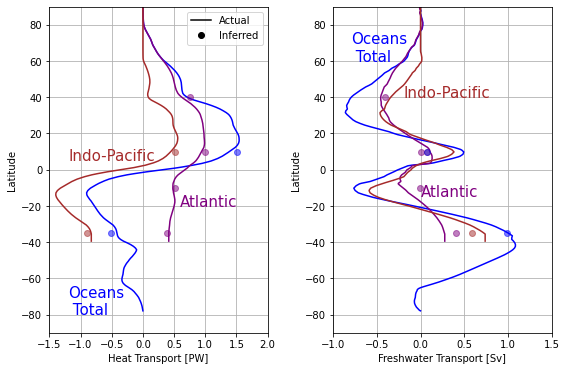

In [38]:
inds_SO = np.argwhere(global_lats>-40)
Atl_lats = np.array([-90,-35,-10,10,40,90])
Pac_lats = np.array([-90,-35,-10,10,90])

fig, axs = plt.subplots(1,2, figsize=(7.5*1.2,5*1.2), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.3)
axs = axs.ravel()

axs[0].plot(north_HF_global, global_lats, color='blue')
axs[0].plot(north_HF_global+20, global_lats, color='black', label='Actual')
axs[0].plot(north_HF_global+20, global_lats, 'ko', label='Inferred')

axs[0].plot((north_HF_Atl-north_HF_Atl[-1])[inds_SO], global_lats[inds_SO], color='purple')
axs[0].plot((north_HF_Pac-north_HF_Pac[-1])[inds_SO]+(north_HF_Ind-north_HF_Ind[-1])[inds_SO], global_lats[inds_SO], color='brown')

axs[0].plot(((HF_section_tot[:4])[::-1]/10**3)[::-1], Atl_lats[::-1][1:-1],  'o', color='purple', alpha=0.5)
axs[0].plot((np.array([HF_section_tot[6]+HF_section_tot[4], HF_section_tot[8]])/10**3)[::-1], [Pac_lats[::-1][1],Pac_lats[::-1][3]] , 'o', color='brown', alpha=0.5)
axs[0].plot((np.concatenate([tot[1:3],tot[4:]])/10**3)[1:-1], np.concatenate([Atl_lats[:2],Atl_lats[3:-1]])[::-1][1:-1],  'o', color='blue', alpha=0.5)
# plt.plot(/10**3, [-35], 'o', color='green', alpha=0.5)

axs[0].legend()
axs[0].set_ylabel('Latitude')
axs[0].set_xlabel('Heat Transport [PW]')
# axs[0].set_title('Meridional Northward Heat Transport [PW]')
axs[0].grid(zorder=-900)
axs[0].set_ylim(-90,90)
axs[0].set_xlim(-1.5,2)
axs[0].text(-1.2,-80,'Oceans\n Total', color='blue', fontsize=15)
axs[0].text(-1.2,5,'Indo-Pacific', color='brown', fontsize=15)
axs[0].text(0.6,-20,'Atlantic', color='purple', fontsize=15)

axs[1].plot(north_FWF_global, global_lats, color='blue')
axs[1].plot(north_FWF_global+20, global_lats, color='black', label='Actual')
axs[1].plot(north_FWF_global+20, global_lats, 'ko', label='Inferred')

axs[1].plot((north_FWF_Atl-north_FWF_Atl[-1])[inds_SO], global_lats[inds_SO], color='purple')
axs[1].plot((north_FWF_Pac-north_FWF_Pac[-1])[inds_SO]+(north_FWF_Ind-north_FWF_Ind[-1])[inds_SO], global_lats[inds_SO], color='brown')

axs[1].plot(-1*((FWF_section_tot[:4])[::-1])[::-1], Atl_lats[::-1][1:-1],  'o', color='purple', alpha=0.5)
axs[1].plot(-1*(np.array([FWF_section_tot[6]+FWF_section_tot[4], FWF_section_tot[8]]))[::-1], [Pac_lats[::-1][1],Pac_lats[::-1][3]] , 'o', color='brown', alpha=0.5)
axs[1].plot(-1*(np.concatenate([tot_FW[1:3],tot_FW[4:]]))[1:-1], np.concatenate([Atl_lats[:2],Atl_lats[3:-1]])[::-1][1:-1],  'o', color='blue', alpha=0.5)
# plt.plot(/10**3, [-35], 'o', color='green', alpha=0.5)

# axs[1].legend()
axs[1].set_ylabel('Latitude')
axs[1].set_xlabel('Freshwater Transport [Sv]')
# axs[1].set_title('Meridional Northward Freshwater Transport [Sv]')
axs[1].grid(zorder=-900)
axs[1].set_ylim(-90,90)
axs[1].set_xlim(-1,1.5)
axs[1].text(-0.8,60,'Oceans\n Total', color='blue', fontsize=15)
axs[1].text(-.2,40,'Indo-Pacific', color='brown', fontsize=15)
axs[1].text(0,-15,'Atlantic', color='purple', fontsize=15)
# plt.vlines(0,-90,90, color='black', zorder=-1000)
# plt.hlines(0,-2,2, color='black', zorder=-1000)

plt.savefig('../Figures/Flux_validation_IPac_ERA5.png', bbox_inches='tight', dpi=300)
plt.show()


In [39]:
Q_adj_basins = np.nansum((Opt_result.dT_adjustment.values*Vol_2*rho*Cp/(range_yrs*yr2sec*1e12)).reshape(9,16), axis=-1)
Q_prior_plus_bias_basins = np.nansum((dT_prior*Vol_1*rho*Cp/(range_yrs*yr2sec*1e12)).reshape(9,16), axis=-1)
dOHC_basins = np.nansum((((Vol_2*T_2)-(Vol_1*T_pre))*rho*Cp/(range_yrs*yr2sec*1e12)).reshape(9,16), axis=-1)
QS_adj_basins = np.nansum((Opt_result.dS_adjustment.values*Vol_2/(range_yrs*yr2sec*S0*1e6)).reshape(9,16), axis=-1)
QS_prior_plus_bias_basins = np.nansum((dS_prior*Vol_1/(range_yrs*yr2sec*S0*1e6)).reshape(9,16), axis=-1)
dOSC_basins = np.nansum((((Vol_2*S_2)-(Vol_1*S_pre))/(range_yrs*yr2sec*S0*1e6)).reshape(9,16), axis=-1)

Q_adj_uniform = np.nansum(Q_adj_basins) *(np.nansum(A_2.reshape(9,16), axis=-1)/np.nansum(A_2))
QS_adj_uniform = -np.nansum(QS_adj_basins) *(np.nansum(A_2.reshape(9,16), axis=-1)/np.nansum(A_2))

dT_bias = (dT_prior - dT_prior_OG)
dS_bias = (dS_prior - dS_prior_OG)

Q_bias = np.nansum((dT_bias*Vol_1*rho*Cp/(range_yrs*yr2sec*1e12)).reshape(9,16), axis=-1)
QS_bias = np.nansum((dS_bias*Vol_1/(range_yrs*yr2sec*S0*1e6)).reshape(9,16), axis=-1)
Q_actual = np.nansum((dT_prior_OG*Vol_1*rho*Cp/(range_yrs*yr2sec*1e12)).reshape(9,16), axis=-1)
QS_actual = np.nansum((dS_prior_OG*Vol_1/(range_yrs*yr2sec*S0*1e6)).reshape(9,16), axis=-1)

Q_bias_global = np.append(Q_bias, Q_bias.sum())
QS_bias_global = np.append(QS_bias, QS_bias.sum())
Q_actual_global = np.append(Q_actual, Q_bias.sum())
QS_actual_global = np.append(QS_actual, QS_bias.sum())

Q_adj_basins_global = np.append(Q_adj_basins, Q_adj_basins.sum())
Q_adj_uniform_global = np.append(Q_adj_uniform, Q_adj_uniform.sum())
Q_prior_plus_bias_basins_global = np.append(Q_prior_plus_bias_basins, Q_prior_plus_bias_basins.sum())
dOHC_basins_global = np.append(dOHC_basins, dOHC_basins.sum())
QS_adj_basins_global = -np.append(QS_adj_basins, QS_adj_basins.sum())
QS_adj_uniform_global = np.append(QS_adj_uniform, QS_adj_uniform.sum())
QS_prior_plus_bias_basins_global = -np.append(QS_prior_plus_bias_basins, QS_prior_plus_bias_basins.sum())
dOSC_basins_global = -np.append(dOSC_basins, dOSC_basins.sum())
net_heat_trans_Basins_global = np.append(net_heat_trans_Basins, np.nansum(net_heat_trans_Basins))
net_salt_trans_Basins_global = -np.append(net_salt_trans_Basins, np.nansum(net_salt_trans_Basins))

In [53]:
Q_bias_global, Q_adj_basins_global

(array([   9.86588109,  214.09930271,  134.79957356,  198.54602779,
         514.91672774,  200.55321207,  368.02646444,  434.00872018,
         624.42932302, 2699.24523261]),
 array([ -117.60200036,  -180.37120457,   -90.79680194,  -129.63443953,
         -351.66267199,  -308.77684035,  -318.02074039,  -474.39985225,
         -720.73922242, -2692.0037738 ]))

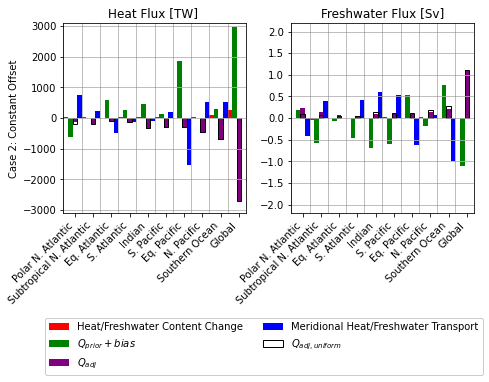

In [49]:
fig, axs = plt.subplots(1,2, figsize=(10.5*0.7,5*0.7), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=0.25)
axs = axs.ravel() 

width = 0.25

axs[0].bar(np.arange(10), dOHC_basins_global, width, color='red',label = 'Heat/Freshwater Content Change')
axs[0].bar(np.arange(10)+width, Q_prior_plus_bias_basins_global, width, color='green', label = '$Q_{prior}+bias$')
axs[0].bar(np.arange(10)+width*2, Q_adj_basins_global, width, color='purple', label = '$Q_{adj}$')
axs[0].bar(np.arange(10)+width*3, net_heat_trans_Basins_global, width, color='blue', label = 'Meridional Heat/Freshwater Transport')
axs[0].bar(np.arange(10) + width * 2, Q_adj_uniform_global, width, color='none', edgecolor='black', alpha=1.0, label='$Q_{adj, uniform}$')

axs[1].bar(np.arange(10), dOSC_basins_global, width, color='red')
axs[1].bar(np.arange(10)+width, QS_prior_plus_bias_basins_global, width, color='green')
axs[1].bar(np.arange(10)+width*2, QS_adj_basins_global, width, color='purple')
axs[1].bar(np.arange(10)+width*3, net_salt_trans_Basins_global, width, color='blue')
axs[1].bar(np.arange(10) + width * 2, QS_adj_uniform_global, width, color='none', edgecolor='black', alpha=1.0, label='$Q_{adj, uniform}$')


# axs[0].bar(np.arange(10), budget_prior.OHC_Change.values, 0.25, color='red', label = 'Heat/Freshwater Content Change')
# axs[0].bar(np.arange(10)+0.25, budget_prior.Surface_Heat_flux_Change.values, 0.25, color='green', label = '$Q_{prior}+bias$')
# axs[0].bar(np.arange(10)+0.5, budget_prior.Adjustment_heat_flux_Change.values, 0.25, color='purple', label = '$Q_{adj}$')
# axs[0].bar(np.arange(10)+0.75, budget_prior.Net_Meridional_Heat_Transport.values, 0.25, color='blue', label = 'Heat/Freshwater Transport')

# axs[2].bar(np.arange(10), budget_no_prior.OHC_Change.values, 0.25, color='red')
# axs[2].bar(np.arange(10)+0.25, budget_no_prior.Surface_Heat_flux_Change.values*0, 0.25, color='green')
# axs[2].bar(np.arange(10)+0.5, budget_no_prior.Adjustment_heat_flux_Change.values, 0.25, color='purple')
# axs[2].bar(np.arange(10)+0.75, budget_no_prior.Net_Meridional_Heat_Transport.values, 0.25, color='blue')

# axs[4].bar(np.arange(10), budget_offset.FW_Change.values, 0.25, color='red')
# axs[4].bar(np.arange(10)+0.25, budget_offset.Surface_FW_flux_Change.values, 0.25, color='green')
# axs[4].bar(np.arange(10)+0.5, budget_offset.Adjustment_FW_flux_Change.values, 0.25, color='purple')
# axs[4].bar(np.arange(10)+0.75, -budget_offset.Net_Meridional_FW_Transport.values, 0.25, color='blue')

# axs[3].bar(np.arange(10), budget_prior.FW_Change.values, 0.25, color='red')
# axs[3].bar(np.arange(10)+0.25, budget_prior.Surface_FW_flux_Change.values, 0.25, color='green')
# axs[3].bar(np.arange(10)+0.5, budget_prior.Adjustment_FW_flux_Change.values, 0.25, color='purple')
# axs[3].bar(np.arange(10)+0.75, -budget_prior.Net_Meridional_FW_Transport.values, 0.25, color='blue')

# axs[5].bar(np.arange(10), budget_no_prior.FW_Change.values, 0.25, color='red')
# axs[5].bar(np.arange(10)+0.25, budget_no_prior.Surface_FW_flux_Change.values*0, 0.25, color='green')
# axs[5].bar(np.arange(10)+0.5, budget_no_prior.Adjustment_FW_flux_Change.values, 0.25, color='purple')
# axs[5].bar(np.arange(10)+0.75, -budget_no_prior.Net_Meridional_FW_Transport.values, 0.25, color='blue')

axs[0].set_title('Heat Flux [TW] ')
axs[1].set_title('Freshwater Flux [Sv]')
# axs[2].set_title('Case 3')

axs[0].set_ylim(-3100,3100)
# axs[1].set_ylim(-1800,1800)
# axs[1].set_ylim(-30,300)

axs[1].set_ylim(-2.2,2.2)
# axs[4].set_ylim(-2.2,2.2)
# axs[5].set_ylim(-0.05,0.05)


for i in range(2):
    axs[i].set_xticklabels(np.append(Basins, 'Global'), rotation=45, ha='right')
    axs[i].set_xticks(np.arange(10)+0.5)
    axs[i].set_xlim(-0.25/2,10-0.25/2)
    axs[i].vlines(np.arange(10)-0.25/2,-4000,4000, color='grey', linewidth=0.5)
    axs[i].grid(axis='y')
# axs[0].set_xticklabels([])
# axs[1].set_xticklabels([])
# axs[2].set_xticklabels([])

axs[0].set_ylabel('Case 2: Constant Offset')
# axs[1].set_ylabel('Freshwater Flux [Sv]')

axs[0].legend(framealpha=1, ncol=2, bbox_to_anchor=(1.1, -0.7), loc='center')

# plt.savefig('../Figures/Heat_FW_budgets.png', bbox_inches='tight', dpi=300)
plt.show()

In [50]:
import os

Q_adj_basins_global_da = xr.DataArray(data = Q_adj_basins_global, dims = ['Basin'], coords = {'Basin': np.append(Basins, 'Global')})
Q_adj_uniform_global_da = xr.DataArray(data = Q_adj_uniform_global, dims = ['Basin'], coords = {'Basin': np.append(Basins, 'Global')})
Q_prior_plus_bias_basins_global_da = xr.DataArray(data = Q_prior_plus_bias_basins_global, dims = ['Basin'], coords = {'Basin': np.append(Basins, 'Global')})
dOHC_basins_global_da = xr.DataArray(data = dOHC_basins_global, dims = ['Basin'], coords = {'Basin': np.append(Basins, 'Global')})
QS_adj_basins_global_da = xr.DataArray(data = QS_adj_basins_global, dims = ['Basin'], coords = {'Basin': np.append(Basins, 'Global')})
QS_adj_uniform_global_da = xr.DataArray(data = QS_adj_uniform_global, dims = ['Basin'], coords = {'Basin': np.append(Basins, 'Global')})
QS_prior_plus_bias_basins_global_da = xr.DataArray(data = QS_prior_plus_bias_basins_global, dims = ['Basin'], coords = {'Basin': np.append(Basins, 'Global')})
dOSC_basins_global_da = xr.DataArray(data = dOSC_basins_global, dims = ['Basin'], coords = {'Basin': np.append(Basins, 'Global')})
net_heat_trans_Basins_global_da = xr.DataArray(data = net_heat_trans_Basins_global, dims = ['Basin'], coords = {'Basin': np.append(Basins, 'Global')})
net_salt_trans_Basins_global_da = xr.DataArray(data = net_salt_trans_Basins_global, dims = ['Basin'], coords = {'Basin': np.append(Basins, 'Global')})
Q_bias_global_da = xr.DataArray(data=Q_bias_global, dims = ['Basin'], coords = {'Basin': np.append(Basins, 'Global')})
QS_bias_global_da = xr.DataArray(data=QS_bias_global, dims = ['Basin'], coords = {'Basin': np.append(Basins, 'Global')})
Q_actual_global_da = xr.DataArray(data=Q_actual_global, dims = ['Basin'], coords = {'Basin': np.append(Basins, 'Global')})
QS_actual_global_da = xr.DataArray(data=QS_actual_global, dims = ['Basin'], coords = {'Basin': np.append(Basins, 'Global')})

ds = xr.Dataset()
ds['OHC_Change'] = dOHC_basins_global_da
ds['Surface_Heat_flux_Change'] = Q_prior_plus_bias_basins_global_da
ds['Adjustment_heat_flux_Change'] = Q_adj_basins_global_da
ds['Bias_heat_flux_Change'] = Q_bias_global_da
ds['Uniform_Adjustment_heat_flux_Change'] = Q_adj_uniform_global_da
ds['Net_Meridional_Heat_Transport'] = net_heat_trans_Basins_global_da
ds['FW_Change'] = dOSC_basins_global_da
ds['Surface_FW_flux_Change'] = QS_prior_plus_bias_basins_global_da
ds['Adjustment_FW_flux_Change'] = QS_adj_basins_global_da
ds['Bias_FW_flux_Change'] = QS_bias_global_da

ds['Actual_heat_flux_Change'] = Q_actual_global_da
ds['Actual_FW_flux_Change'] = QS_actual_global_da

ds['Uniform_Adjustment_FW_flux_Change'] = QS_adj_uniform_global_da
ds['Net_Meridional_FW_Transport'] = net_salt_trans_Basins_global_da

file_path = '../Optimisation_results/ACCESS_CM2_known_ERA5_budget.nc'
if os.path.exists(file_path):
    os.remove(file_path)
    print('File deleted')
ds.to_netcdf(file_path)

File deleted


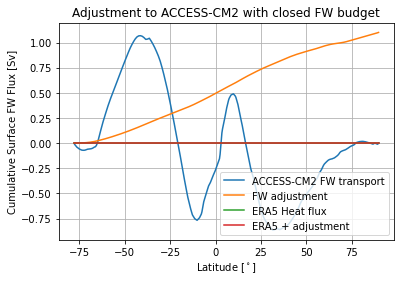

In [51]:
(wfo_ACCESS_m3.sum('xt_ocean').cumsum('yt_ocean')/(range_yrs*yr2sec*1e6)).plot(label = 'ACCESS-CM2 FW transport')
(dwfo_adj_remapped_m3.sum('xt_ocean').cumsum('yt_ocean')/(range_yrs*yr2sec*1e6)).plot(label = 'FW adjustment')
(wfo_ERA5_m3.sum('xt_ocean').cumsum('yt_ocean')/(range_yrs*yr2sec*1e15)).plot(label = 'ERA5 Heat flux')
((wfo_ERA5_m3+dwfo_adj_remapped_m3).sum('xt_ocean').cumsum('yt_ocean')/(range_yrs*yr2sec*1e15)).plot(label = 'ERA5 + adjustment')
plt.ylabel('Cumulative Surface FW Flux [Sv]')
plt.xlabel('Latitude [$^\circ$]')
plt.title('Adjustment to ACCESS-CM2 with closed FW budget')
plt.legend()
plt.grid()
# plt.savefig('../Figures/ERA5_ACCESS_CM2_adjustment_cumsum.png', dpi=330, bbox_inches='tight')
plt.show()

______
